In [100]:
import pathlib

from heliostack.image import Image

import torch
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('mps')

In [101]:
image_paths = list(pathlib.Path('/Users/kjnapier/Desktop/research/data/jts/B1a/20201018/CCD5/').glob('*.diff.rescale.fits.fz'))
weight_paths = list(pathlib.Path('/Users/kjnapier/Desktop/research/data/jts/B1a/20201018/CCD5/').glob('*.diff.weight.fits.fz'))
assert len(image_paths) == len(weight_paths)

In [102]:
images = []
for i, w in zip(image_paths, weight_paths):
    im = fits.open(i)
    wt = fits.open(w)

    wcs = WCS(im[1].header)
    epoch = Time(im[1].header['MJD-OBS'], format='mjd', scale='utc')

    image = Image(im[1].data, wt[1].data, wcs, epoch, device=device)
    images.append(image)


In [141]:
# phi = torch.zeros(2500, 5000, device=device, dtype=torch.half)
# psi = torch.zeros(2500, 5000, device=device, dtype=torch.half)

phi = torch.zeros(2500, 5000, device=device, dtype=torch.half)
psi = torch.zeros(2500, 5000, device=device, dtype=torch.half)

In [142]:
phi.storage().data_ptr()   # original storage()

24415230592

In [143]:
%%time

for im in images:
    dx, dy = im.image.shape
    phi[0:dx, 0:dy] += im.image
    #phi += im.image

CPU times: user 16.6 ms, sys: 183 ms, total: 199 ms
Wall time: 243 ms


In [144]:
phi.storage().data_ptr() 

24415230592

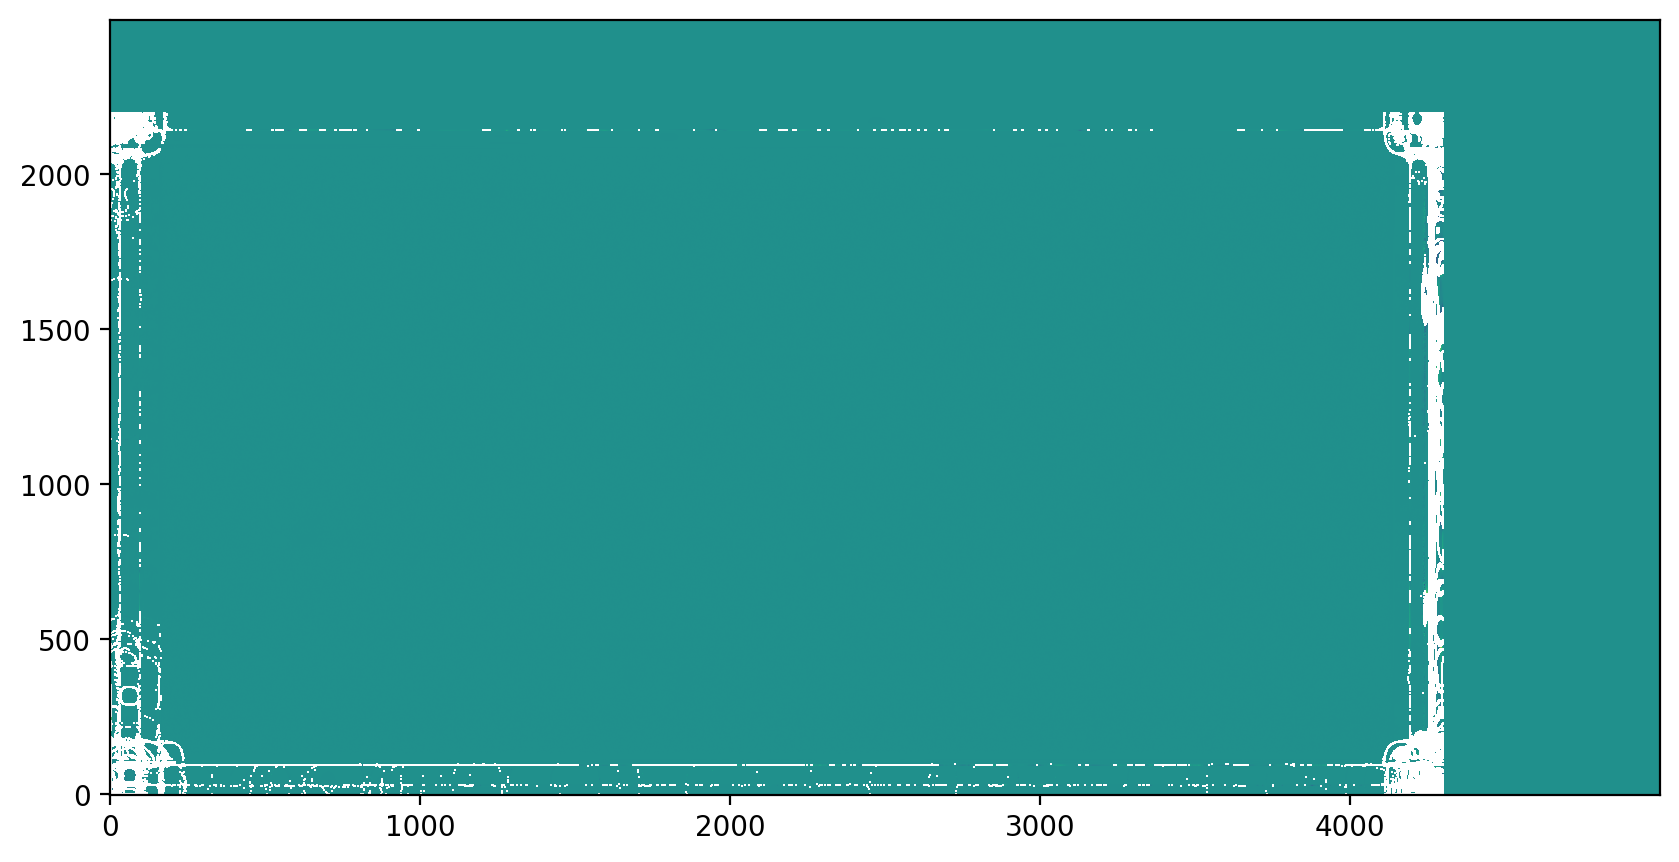

In [130]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow((phi).cpu().numpy(), origin='lower')